## Wine_Benchmarks数据集异常检测

In [12]:
import pandas as pd
import os


# 预处理数据
def pre_process(data):

    data.drop(['point.id', 'motherset', 'origin', 'original.label'], axis=1, inplace=True)
    data['ground.truth'] = data['ground.truth'].map({'nominal': 0, 'anomaly': 1})

    y = data['ground.truth']
    X = data.drop('ground.truth', axis=1)
    
    return X, y

### 定义11种异常检测分类器

In [ ]:
# 定义分类器
def load_classifiers(outliers_fraction):
    outliers_fraction = min(0.5, outliers_fraction)
    random_state = np.random.RandomState(42)
    # Define nine outlier detection tools to be compared
    classifiers = {
    'Angle-based Outlier Detector (ABOD)':
            ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
            CBLOF(contamination=outliers_fraction,
                      check_estimator=False, random_state=random_state),
    'Feature Bagging':
            FeatureBagging(LOF(n_neighbors=35),
                                       contamination=outliers_fraction,
                                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                                            random_state=random_state, behaviour="new"),
    'K Nearest Neighbors (KNN)': KNN(
            contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
            LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state)
    }
    return classifiers

### 加载数据并训练模型

In [ ]:
import pickle
from tqdm import tqdm
import warnings
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
warnings.filterwarnings("ignore")

PATH = "wine/benchmarks"
fns = os.listdir(PATH)

for i in tqdm(range(len(fns))):
    fn = fns[i]
    data = pd.read_csv(os.path.join(PATH, fn))
    X, y = pre_process(data)
    
    outliers_fraction = y.sum()/len(y)
    classifiers = load_classifiers(outliers_fraction)
    
    all_scores = {}
    for i, (name, clf) in enumerate(classifiers.items()):
        if i==11: # 最后一种方法太耗时，故不使用
            continue
        clf.fit(X)
        y_pred = clf.predict(X)

        scores = []
        scores.append(roc_auc_score(y, y_pred))
        scores.append(f1_score(y, y_pred))
        scores.append(precision_score(y, y_pred))
        scores.append(recall_score(y, y_pred))
        all_scores[name] = scores

    with open('result/{}'.format(fn), 'wb') as f:
        pickle.dump(all_scores, f)

### 分析实验结果

In [13]:
import pickle
import os
import pandas as pd
from tqdm import tqdm


fns = os.listdir('result')

result = []
for i in tqdm(range(len(fns))):
    fn = fns[i]
    with open(os.path.join('result', fn), 'rb') as f:
        score = pickle.load(f)
        
    for k, v in score.items():
        row = [fn, k] + v
        result.append(row)

result = pd.DataFrame(result, columns=['filename', 'models', 'roc', 'f1_score', 'precision', 'recall'])
result.to_csv('result.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:05<00:00, 205.52it/s]


### 测试模型

In [35]:
# 计算每个模型在所有文件上的指标平均值
roc = result.groupby('models')['roc', 'f1_score', 'precision', 'recall'].apply(lambda x: x.mean())
# 按ROC值排序
roc = roc.sort_values(by='roc')

### 比较模型指标

**实验中使用了四种指标评估模型的检测效果：** 
* ROC: 基于ROC曲线计算得到的平均值  
* f1_score: 2\*precision\*recall/(precision + recall)  
* precision: 准确率  
* recall: 召回率

**结果分析:**
* 从各项指标上看，效果最好的模型是PCA, 明显优于其他模型, 其次是HBOS、Isolation Forest和MCD  
* 效果最差的模型是Average KNN， 较差的模型有One-class SVM、CBLOF、LOF等，这些模型差距较小  
* 不同的指标具有一致性，即同一模型，各项指标都较高，或都较低


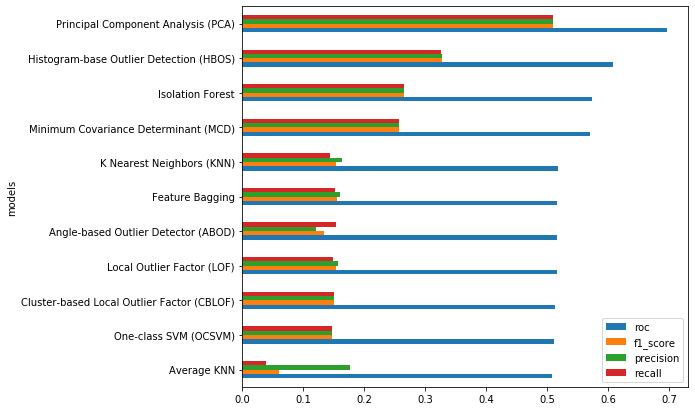

In [51]:
roc.plot.barh(figsize=(8, 7))